# Sparkify Project Workspace (Mini Dataset)
This workspace was used to explore a smaller subset (128MB) of the music event data with Spark. The plan is to  deploy an ML cluster on the IBM cloud using a larger dataest at a later date.

In [1]:
#Import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import IntegerType, TimestampType
from pyspark.sql.functions import isnan, when, count, col, concat_ws, avg
from pyspark.sql.functions import asc, desc, explode, lit, min, max, split
from pyspark.sql.functions import sum as Fsum, udf, countDistinct, date_format
from pyspark.sql.functions import when, to_date, lag, coalesce

import random
import re
import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
#Create a local Spark session since using a mini-dataset suitable for local exploration
spark = SparkSession.builder\
                    .master('local')\
                    .appName('SparkifyApp')\
                    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

**1st step** to view the dataframe contents and data types below.

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#Total number of records 
df.count()

286500

Using describe() on subsets of dataframe columns to more easily view summary stats in tables.

In [7]:
df.describe('userId', 'firstName', 'lastName', 'gender', 'status', 
            'level', 'registration').show()

+-------+-----------------+---------+--------+------+------------------+------+--------------------+
|summary|           userId|firstName|lastName|gender|            status| level|        registration|
+-------+-----------------+---------+--------+------+------------------+------+--------------------+
|  count|           286500|   278154|  278154|278154|            286500|286500|              278154|
|   mean|59682.02278593872|     null|    null|  null|210.05459685863875|  null|1.535358834084427...|
| stddev|109091.9499991047|     null|    null|  null| 31.50507848842214|  null| 3.291321616327586E9|
|    min|                 | Adelaida|   Adams|     F|               200|  free|       1521380675000|
|    max|               99|   Zyonna|  Wright|     M|               404|  paid|       1543247354000|
+-------+-----------------+---------+--------+------+------------------+------+--------------------+



In [8]:
df.describe('artist', 'song', 'length', 'auth', 'page', 'method').show()

+-------+------------------+--------------------+-----------------+----------+-------+------+
|summary|            artist|                song|           length|      auth|   page|method|
+-------+------------------+--------------------+-----------------+----------+-------+------+
|  count|            228108|              228108|           228108|    286500| 286500|286500|
|   mean| 551.0852017937219|            Infinity|249.1171819778458|      null|   null|  null|
| stddev|1217.7693079161374|                 NaN|99.23517921058361|      null|   null|  null|
|    min|               !!!|ÃÂg ÃÂtti Gr...|          0.78322| Cancelled|  About|   GET|
|    max| ÃÂlafur Arnalds|ÃÂau hafa slopp...|       3024.66567|Logged Out|Upgrade|   PUT|
+-------+------------------+--------------------+-----------------+----------+-------+------+



In [9]:
df.describe('sessionId', 'itemInSession', 'ts', 'userAgent', 'location').show()

+-------+-----------------+------------------+--------------------+--------------------+-----------------+
|summary|        sessionId|     itemInSession|                  ts|           userAgent|         location|
+-------+-----------------+------------------+--------------------+--------------------+-----------------+
|  count|           286500|            286500|              286500|              278154|           278154|
|   mean|1041.526554973822|114.41421291448516|1.540956889810483...|                null|             null|
| stddev|726.7762634630741|129.76726201140994|1.5075439608226302E9|                null|             null|
|    min|                1|                 0|       1538352117000|"Mozilla/5.0 (Mac...|       Albany, OR|
|    max|             2474|              1321|       1543799476000|Mozilla/5.0 (comp...|Winston-Salem, NC|
+-------+-----------------+------------------+--------------------+--------------------+-----------------+



In [10]:
#Count distinct values for each column
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).head()

Row(artist=17655, auth=4, firstName=189, gender=2, itemInSession=1322, lastName=173, length=14865, level=2, location=114, method=2, page=22, registration=225, sessionId=2354, song=58480, status=3, ts=277447, userAgent=56, userId=226)

From the above column counts it looks like every user log record has a 'userId' but some are missing user information like 'firstName', 'lastName', 'gender' and 'registration'.

In [11]:
df.filter(df.lastName.isNull()).show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [12]:
#Total number of records 
df.count()

286500

In [13]:
df.filter(df.lastName.isNull()).count()

8346

In [14]:
df.filter(df.userId=='').count()

8346

From the above cells, the records with missing lastName appear to also have userId=''. 

Exclude these records since these will not provide any helpful information regarding churn. These users are either not yet logged in, or just browsing and cannot be identified as at a starting payment tier.

In [15]:
#Exclude userId='' records and check updated recordcount
df = df.filter(df.userId!='')
df.count()

278154

#### Add date columns to help aggregate by day, hour etc. For both the 'ts' and 'registration'.

In [16]:
#Udfs to derive the year, month, day and hour from the timestamp formats
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).year)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).month) 
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day) 
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)

#Use above udfs to create new columns
df = df.withColumn('year', get_year(col('ts')))
df = df.withColumn('month', get_month(col('ts')))
df = df.withColumn('day', get_day(col('ts')))
df = df.withColumn('hour', get_hour(col('ts')))

#Concatenate new cols as new date format column
cols = ["year","month","day"]
df = df.withColumn("date", to_date(concat_ws("-",*cols),"yyyy-MM-dd") \
                   .cast("date"))

In [17]:
#As above using registration timestamp
df = df.withColumn('reg_year', get_year(col('registration')))
df = df.withColumn('reg_month', get_month(col('registration')))
df = df.withColumn('reg_day', get_day(col('registration')))

cols = ["reg_year","reg_month","reg_day"]
df = df.withColumn("reg_date", to_date(concat_ws("-",*cols),"yyyy-MM-dd") \
                   .cast("date"))

Examining the available user interactions columns, 'page' seems to be the most useful descriptor of user engagement. 'auth' and 'method' can be ignored as they don't seem to add additional value.

In [18]:
df.select('auth','page', 'method').dropDuplicates().sort('page').show()

+---------+--------------------+------+
|     auth|                page|method|
+---------+--------------------+------+
|Logged In|               About|   GET|
|Logged In|          Add Friend|   PUT|
|Logged In|     Add to Playlist|   PUT|
|Logged In|              Cancel|   PUT|
|Cancelled|Cancellation Conf...|   GET|
|Logged In|           Downgrade|   GET|
|Logged In|               Error|   GET|
|Logged In|                Help|   GET|
|Logged In|                Home|   GET|
|Logged In|              Logout|   PUT|
|Logged In|            NextSong|   PUT|
|Logged In|         Roll Advert|   GET|
|Logged In|       Save Settings|   PUT|
|Logged In|            Settings|   GET|
|Logged In|    Submit Downgrade|   PUT|
|Logged In|      Submit Upgrade|   PUT|
|Logged In|         Thumbs Down|   PUT|
|Logged In|           Thumbs Up|   PUT|
|Logged In|             Upgrade|   GET|
+---------+--------------------+------+



Closer examination of columns I am not sure of. 'userAgent' seems to correspond to the method the user has used to access the music platform service, while the location is likely the user's location. 'length' could be the length of the track being listened to. The 'status' column I am still unsure of. These last 4 columns I do not think will add much to the model. I think creating dummy columns for each location or userAgent will add too many columns and I do not think will add much to the investigation, except unnecessary complexity.

In [19]:
df.select('userId', 'sessionId', 'itemInSession', 'ts', 'userAgent', 
          'location', 'length', 'status').show(5)

+------+---------+-------------+-------------+--------------------+--------------------+---------+------+
|userId|sessionId|itemInSession|           ts|           userAgent|            location|   length|status|
+------+---------+-------------+-------------+--------------------+--------------------+---------+------+
|    30|       29|           50|1538352117000|Mozilla/5.0 (Wind...|     Bakersfield, CA|277.89016|   200|
|     9|        8|           79|1538352180000|"Mozilla/5.0 (Win...|Boston-Cambridge-...|236.09424|   200|
|    30|       29|           51|1538352394000|Mozilla/5.0 (Wind...|     Bakersfield, CA| 282.8273|   200|
|     9|        8|           80|1538352416000|"Mozilla/5.0 (Win...|Boston-Cambridge-...|262.71302|   200|
|    30|       29|           52|1538352676000|Mozilla/5.0 (Wind...|     Bakersfield, CA|223.60771|   200|
+------+---------+-------------+-------------+--------------------+--------------------+---------+------+
only showing top 5 rows



In [20]:
df.filter(df.sessionId==29).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----+-----+---+----+----------+--------+---------+-------+----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|year|month|day|hour|      date|reg_year|reg_month|reg_day|  reg_date|
+--------------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----+-----+---+----+----------+--------+---------+-------+----------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|       NextSong|

However, looking at the above example session, 'sessionId' appears to correspond to individual user login sessions, with the 'itemInSession' logging each user interaction within a session. Both columns should be useful as features to summarise user behaviour.

# Exploratory Data Analysis

### Define churn

Create columns `cancelled` and `downgrade` to label those users/events we are interested in investigating. And together they will be used to create a `churn` column to use as the label for the model.

In [21]:
#UDFs to flag user events which have a 'Cancellation Confirmation' or 'Submit Downgrade' as 1 
#then create new 'cancelled' and 'downgraded' columns from these
flag_cancelled = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0
                     , IntegerType())
df = df.withColumn('cancelled', flag_cancelled('page'))

flag_downgrade = udf(lambda x: 1 if x=='Submit Downgrade' else 0
                     , IntegerType())
df = df.withColumn('downgraded', flag_downgrade('page'))

In [22]:
#Define window partition to tag all events prior to 'Cancellation Confirmation' or 'Submit Downgrade' event.
windowval = Window.partitionBy('userId') \
                .orderBy(desc('ts')) \
                .rangeBetween(Window.unboundedPreceding,0)
        
df = df.withColumn('pre_cancelled_events',Fsum('cancelled').over(windowval))
df = df.withColumn('pre_downgraded_events',Fsum('downgraded').over(windowval))

Below looking at example sessions to track how the 'page' and above newly added columns transition from pre churn events through time.

In [23]:
#Example user pre_downgraded_events
df.select(['userId','firstname','ts','page','level','downgraded',
           'pre_downgraded_events','cancelled','pre_cancelled_events'
          ]) \
        .where(df.pre_downgraded_events=='1') \
        .sort(['userId','ts'], ascending=False) \
        .dropDuplicates().show(10)

+------+----------+-------------+----------------+-----+----------+---------------------+---------+--------------------+
|userId| firstname|           ts|            page|level|downgraded|pre_downgraded_events|cancelled|pre_cancelled_events|
+------+----------+-------------+----------------+-----+----------+---------------------+---------+--------------------+
|    96|Alexandria|1541722970000|Submit Downgrade| paid|         1|                    1|        0|                   0|
|    96|Alexandria|1541722969000|       Downgrade| paid|         0|                    1|        0|                   0|
|    96|Alexandria|1541722956000|        NextSong| paid|         0|                    1|        0|                   0|
|    96|Alexandria|1541722674000|        NextSong| paid|         0|                    1|        0|                   0|
|    96|Alexandria|1541722415000|        NextSong| paid|         0|                    1|        0|                   0|
|    96|Alexandria|1541722188000

In [24]:
#Example user pre_cancelled_events
df.select(['userId','firstname','ts','page','level','downgraded',
           'pre_downgraded_events','cancelled','pre_cancelled_events']) \
        .where(df.pre_cancelled_events=='1') \
        .sort(['userId','ts'], ascending=False) \
        .dropDuplicates().show()

+------+---------+-------------+--------------------+-----+----------+---------------------+---------+--------------------+
|userId|firstname|           ts|                page|level|downgraded|pre_downgraded_events|cancelled|pre_cancelled_events|
+------+---------+-------------+--------------------+-----+----------+---------------------+---------+--------------------+
|    87|Christian|1540050556000|Cancellation Conf...| paid|         0|                    0|        1|                   1|
|    87|Christian|1540050538000|              Cancel| paid|         0|                    0|        0|                   1|
|    87|Christian|1540050537000|           Downgrade| paid|         0|                    0|        0|                   1|
|    87|Christian|1540050464000|            NextSong| paid|         0|                    0|        0|                   1|
|    87|Christian|1540050304000|            NextSong| paid|         0|                    0|        0|                   1|
|    87|

Checking that downgrade submission results in a change from paid tier to free tier.

In [25]:
#Create lists of downgraded and cancelled users
downgraded_users = [int(row.userId) for row in df.select('userId').where(
    df.page=='Submit Downgrade').dropDuplicates().collect()]

cancelled_users = [int(row.userId) for row in df.select('userId').where(
    df.page=='Cancellation Confirmation').dropDuplicates().collect()]

In [26]:
downgraded_users[:5]

[54, 11, 30, 59, 85]

Pivoting on tier 'level' for downgraded users.

In [27]:
others_pivot = df.select('userId','level').dropDuplicates() \
    .filter(df.userId.isin(downgraded_users)) \
    .groupBy("userId") \
    .pivot("level") \
    .count()

In [28]:
others_pivot.show(5)

+------+----+----+
|userId|free|paid|
+------+----+----+
|    54|   1|   1|
|    11|   1|   1|
|    30|   1|   1|
|    59|   1|   1|
|    85|   1|   1|
+------+----+----+
only showing top 5 rows



From above, downgraded users appear to change to free tier since these users have both paid and free records.

Free only users should be excluded from the model since we are not really interested in users we are not making money from. They can be targetted with a specific sales campaign.

In [29]:
#Created an others_pivot for user not in the above downgraded or cancelled users lists
others_pivot = df.select('userId','level').dropDuplicates() \
    .filter(~df.userId.isin(downgraded_users)&~df.userId.isin(cancelled_users)) \
    .groupBy("userId") \
    .pivot("level") \
    .count()

#Of these other users free only users are ones who have no paid tier records
free_only_users = [int(row.userId) for row in others_pivot.select('userId').where(
    others_pivot.paid.isNull()).collect()]

In [30]:
free_only_users[:5]

[100010, 7, 154, 112, 64]

Add add new column 'user_type' to distingish between downgraded, cancelled, free only, and other paying users.

In [31]:
df = df.withColumn('user_type', \
    when(df.userId.isin(downgraded_users),lit('downgraded')) \
    .when(df.userId.isin(cancelled_users),lit('cancelled')) \
    .when(df.userId.isin(free_only_users),lit('free only')) \
     .otherwise(lit('paying')) )

Create new 'churn' column to use as model label.

In [32]:
df = df.withColumn('churn', \
    when(df.userId.isin(downgraded_users),lit(1)) \
    .when(df.userId.isin(cancelled_users),lit(1)) \
    .otherwise(lit(0)) )

### Explore Data
Once you've defined cancelled, perform some exploratory data analysis to observe the behavior for users who stayed vs users who cancelled. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Looking at an example of a user who downgraded, to see if there are any obvious patterns in interactions before downgrading.

In [33]:
#Check the number of records for this example user so that I can show() all records
df.select(['userId','firstname','sessionId','ts','page','level','downgraded',
           'pre_downgraded_events']) \
        .where((df.userId=='11') & (df.page!='NextSong')) \
        .sort('ts', ascending=False).count()

201

In [34]:
#Excluding NextSong from the sample to reduce records
df.select(['userId','firstname','sessionId','ts','page','level','downgraded',
           'pre_downgraded_events']) \
        .where((df.userId=='11') & (df.page!='NextSong')) \
        .sort('ts', ascending=False).show(200)

+------+---------+---------+-------------+----------------+-----+----------+---------------------+
|userId|firstname|sessionId|           ts|            page|level|downgraded|pre_downgraded_events|
+------+---------+---------+-------------+----------------+-----+----------+---------------------+
|    11|      Zoe|     2092|1543308850000|       Thumbs Up| paid|         0|                    0|
|    11|      Zoe|     2092|1543308631000|       Thumbs Up| paid|         0|                    0|
|    11|      Zoe|     2092|1543306154000|       Thumbs Up| paid|         0|                    0|
|    11|      Zoe|     2092|1543305128000| Add to Playlist| paid|         0|                    0|
|    11|      Zoe|     2016|1542667700000|       Thumbs Up| paid|         0|                    0|
|    11|      Zoe|     2016|1542664926000|            Home| paid|         0|                    0|
|    11|      Zoe|     2016|1542664189000|       Downgrade| paid|         0|                    0|
|    11|  

Though the above user starts on a free tier before changing to a paid tier, they then do the opposite within the same session, visiting 'Downgrade' and 'Submit Downgrade'. All tagged as '1' within 'pre_downgraded_events'. 

This user then upgraded again a while later but it would not been within the scope of this project to consider future upgrades so will be ignored.

#### limit records for churned users
To save time filtering/tidy up the code a bit I am creating 'df_sub' which is a subset of original df, limiting the user logs to those those pre-churn events I am interested (for churned users), all event logs are included for other users.

In [35]:
df_sub = df.filter(((df.user_type=='downgraded') & (df.pre_downgraded_events=='1')) | 
                        ((df.user_type=='cancelled') & (df.pre_cancelled_events=='1')) | 
                        (df.user_type.isin(['free only','paying'])))

#### add 'upgrage date' column
Where above I stated that future upgrades which take place after a user has churned are beyond the scope of this project, upgrades that take place prior might be relevant. Some platform will start their billing cycle at the point of upgrade to a paid, meaning that a day, week, month or year after that upgrade date would be when they were charged fo the service. I think that knowing the billing cycle could be very useful for the model as this could impact when paying users would decide to churn.

In [36]:
df_sub.where(df_sub.page=='Submit Upgrade') \
        .groupBy('userId','user_type') \
        .agg(max('date').alias('upgrade_date')).show()

+------+----------+------------+
|userId| user_type|upgrade_date|
+------+----------+------------+
|200002|    paying|  2018-10-18|
|   155|    paying|  2018-11-09|
|   132|    paying|  2018-10-02|
|   101| cancelled|  2018-10-02|
|    11|downgraded|  2018-10-11|
|   138|    paying|  2018-10-22|
|    29| cancelled|  2018-10-08|
|    69|    paying|  2018-10-07|
|    42|    paying|  2018-10-07|
|    73| cancelled|  2018-10-03|
|    87| cancelled|  2018-10-20|
|   113|    paying|  2018-10-03|
|    59|downgraded|  2018-10-05|
|   139|    paying|  2018-11-01|
|    28| cancelled|  2018-10-29|
|300018|    paying|  2018-10-15|
|300012|    paying|  2018-10-05|
|    85|downgraded|  2018-10-20|
|    16|    paying|  2018-10-04|
|    35|downgraded|  2018-10-25|
+------+----------+------------+
only showing top 20 rows



In [37]:
#Join df_sub with a new upgrade_date column showing the last 'Submit Upgrade' date per user
df_sub = df_sub.join(df_sub.where(df_sub.page=='Submit Upgrade') \
        .groupBy('userId') \
        .agg(max('date').alias('upgrade_date')), on=['userId'], how='left')

At this point I have noticed that because not every user has a Submit Upgrade event with this mini dataset there will be some NaNs in the above new column, which is why I uses a 'left' join and not an 'inner' join.

This may cause me an issue later on when I attempt to calculate how many days there are between the upgrade date and last recorded interaction, per user. To solve this I will add a proxy date (datetime.date(1900, 1, 1)) that I produce a huge date variance which can easily be excluded from any graphs or queries.

In [44]:
#Add new column to summary to calculate the number of days since upgrading
df_sub = df_sub.withColumn('upgrade_date',     
                                       when(df_sub.upgrade_date.isNull(), \
                                            datetime.date(1900, 1, 1)) \
                                        .otherwise(df_sub.upgrade_date) \
                                       )

In [38]:
df_sub.filter(df_sub.userId=='139').head()

Row(userId='139', artist=None, auth='Logged In', firstName='Jaderion', gender='M', itemInSession=9, lastName='Clark', length=None, level='paid', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='Logout', registration=1535271638000, sessionId=1960, song=None, status=307, ts=1542825026000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D167 Safari/9537.53"', year='2018', month='11', day='21', hour='18', date=datetime.date(2018, 11, 21), reg_year='2018', reg_month='8', reg_day='26', reg_date=datetime.date(2018, 8, 26), cancelled=0, downgraded=0, pre_cancelled_events=0, pre_downgraded_events=0, user_type='paying', churn=0, upgrade_date=datetime.date(2018, 11, 1))

#### Summarizing data at user level

Aggregating records per user to see if there are any overall patterns in behaviour across 'user_type's.

Limited records to exclude post downgraded/cancelled events for those user-types, but included free only and other paying users to compare their behaviour vs churned users.

In [39]:
user_summary = df_sub \
    .groupBy('userId','user_type', 'reg_date','churn','upgrade_date') \
    .agg(max('date').alias('max_date'), \
         min('date').alias('min_date'), \
         countDistinct('sessionId').alias('cnt_sessionId'), \
         count('itemInSession').alias('cnt_itemInSession')) 

In [40]:
#Pivot page column to summarize the page visit data per user
user_pivot = df_sub \
    .groupBy("userId") \
    .pivot("page") \
    .count()

In [41]:
#Join the 2 together on userId
user_summary = user_summary.join(user_pivot, on=['userId'], how='inner')

Add new columns to 'user_summary' to calculate the length of membership to the sparkify before downgrading/cancelling, and to calculate the length of the event data date range, per user.

In [42]:
#Udfs to calculate the difference in days between 2 dates
date_diff = udf(lambda x,y: x - y)
delta_days = udf(lambda x: x.days)

In [43]:
#Add new column to summary to calculate the length of membership to the sparkify before churning, or to current day
col_diff = date_diff(user_summary.max_date, user_summary.reg_date)
user_summary = user_summary.withColumn('days_membership', delta_days(col_diff) \
                                       .cast(IntegerType()))

In [45]:
#Add new column to summary to calculate the number of days since upgrading
col_diff = date_diff(user_summary.max_date, user_summary.upgrade_date)
user_summary = user_summary.withColumn('days_since_upgrade',     
                                       when(user_summary.upgrade_date.isNull(),lit(999)) \
                                        .otherwise(delta_days(col_diff)) \
                                       .cast(IntegerType()))

In [46]:
#New column to calculate the length of the event data date range, per user 
col_diff = date_diff(user_summary.max_date, user_summary.min_date)
user_summary = user_summary.withColumn('days_range', delta_days(col_diff) \
                                       .cast(IntegerType()))

In [47]:
user_summary.filter(user_summary.userId=='7').head()

Row(userId='7', user_type='free only', reg_date=datetime.date(2018, 9, 11), churn=0, upgrade_date=datetime.date(1900, 1, 1), max_date=datetime.date(2018, 11, 23), min_date=datetime.date(2018, 10, 3), cnt_sessionId=7, cnt_itemInSession=201, About=None, Add Friend=1, Add to Playlist=5, Cancel=None, Cancellation Confirmation=None, Downgrade=None, Error=1, Help=1, Home=10, Logout=3, NextSong=150, Roll Advert=16, Save Settings=1, Settings=3, Submit Downgrade=None, Submit Upgrade=None, Thumbs Down=1, Thumbs Up=7, Upgrade=2, days_membership=73, days_since_upgrade=43425, days_range=51)

### Visualisations
Convert to dataframe so that I can view graphs

In [49]:
user_summary_pd = user_summary.toPandas()
user_summary_pd.head()

,userId,user_type,reg_date,churn,upgrade_date,max_date,min_date,cnt_sessionId,cnt_itemInSession,About,...,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership,days_since_upgrade,days_range
0,100010,free only,2018-09-27,0,1900-01-01,2018-11-21,2018-10-08,7,381,1.0,...,NaN,NaN,NaN,NaN,5.0,17.0,2.0,55,43423,44
1,200002,paying,2018-09-06,0,2018-10-18,2018-11-15,2018-10-01,6,474,3.0,...,NaN,3.0,NaN,1.0,6.0,21.0,2.0,70,28,45
2,125,cancelled,2018-08-01,1,1900-01-01,2018-10-12,2018-10-12,1,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,43383,0
3,124,paying,2018-07-22,0,1900-01-01,2018-11-30,2018-10-01,29,4825,7.0,...,6.0,20.0,NaN,NaN,41.0,171.0,NaN,131,43432,60
4,51,cancelled,2018-09-27,1,1900-01-01,2018-10-17,2018-10-01,10,2464,2.0,...,1.0,12.0,NaN,NaN,21.0,100.0,NaN,20,43388,16


In [50]:
user_summary_pd.shape

(225, 31)

#### Replace all NaNs
Replace all NaNs with 0 since in these cases NaN means that the user has visited that page 0 times.

In [51]:
user_summary_pd = user_summary_pd.fillna(0)

Comparing the number of users per 'user_type' below, paying users (or users who do not fall into the other 3 categories have the highest number, while the other user_types have roughly the same number.

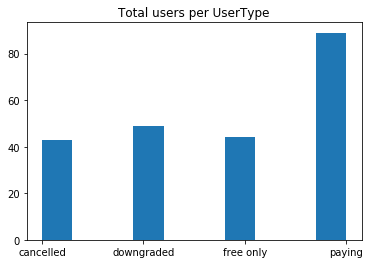

In [52]:
plt.hist(user_summary_pd.user_type)
plt.title('Total users per UserType'); 

Create a correlation matrix to see if there is any obvious correlation between 'churn' and the other columns at the total summary level.

In [53]:
cols = ['cnt_sessionId','cnt_itemInSession','About','Add Friend','Add to Playlist',
            'Cancel','Cancellation Confirmation','Submit Downgrade',
            'Downgrade','Error','Help','Home','Logout','NextSong','Roll Advert',
            'Save Settings','Settings','Submit Upgrade','Thumbs Down','Thumbs Up',
            'Upgrade','days_membership','days_range','days_since_upgrade', 'churn']

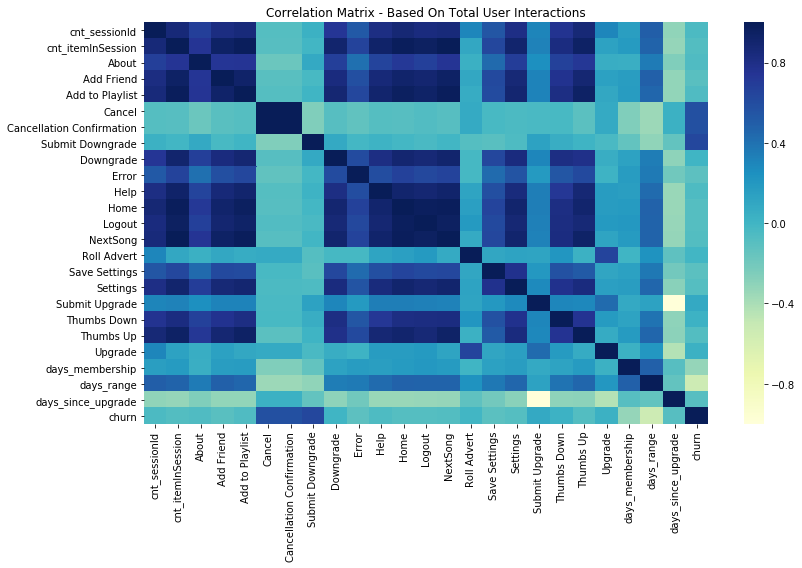

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(user_summary_pd[cols].corr(), cmap="YlGnBu")
ax.set_title("Correlation Matrix - Based On Total User Interactions")
plt.tight_layout()
plt.show()

'churn' has high correlation to 'Cancel', 'Cancellation Confirmation' and 'Submit Downgrade', obviously since it is derived from these columns, but only very weak correlation to other columns.

There is a high number of other columns with strong correlation to each other but I suspect time is factor here so averaging over time might weaken the correlation in some cases.

#### user_summary_pd_per_day
Create a new dataframe averaging all interactions per user across the dateset. This should normalise the users so that I can compare different types of users regardless of the length of membership or when they churned.

In [55]:
user_summary_pd_per_day = user_summary_pd.copy()
cols_per_day = ['cnt_sessionId','cnt_itemInSession','About','Add Friend','Add to Playlist',
            'Cancel','Cancellation Confirmation','Submit Downgrade',
            'Downgrade','Error','Help','Home','Logout','NextSong','Roll Advert',
            'Save Settings','Settings','Submit Upgrade','Thumbs Down','Thumbs Up',
            'Upgrade',
                #'days_membership','days_since_upgrade', 'churn'
                'days_range']

#Divide all summed columns by 'days_range'
user_summary_pd_per_day[cols_per_day] = user_summary_pd_per_day[cols_per_day] \
    .div(user_summary_pd_per_day.days_range, axis=0)

user_summary_pd_per_day.head()

,userId,user_type,reg_date,churn,upgrade_date,max_date,min_date,cnt_sessionId,cnt_itemInSession,About,...,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership,days_since_upgrade,days_range
0,100010,free only,2018-09-27,0,1900-01-01,2018-11-21,2018-10-08,0.159091,8.659091,0.022727,...,0.0000,0.000000,0.0,0.000000,0.113636,0.386364,0.045455,55,43423,1.0
1,200002,paying,2018-09-06,0,2018-10-18,2018-11-15,2018-10-01,0.133333,10.533333,0.066667,...,0.0000,0.066667,0.0,0.022222,0.133333,0.466667,0.044444,70,28,1.0
2,125,cancelled,2018-08-01,1,1900-01-01,2018-10-12,2018-10-12,inf,inf,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,43383,NaN
3,124,paying,2018-07-22,0,1900-01-01,2018-11-30,2018-10-01,0.483333,80.416667,0.116667,...,0.1000,0.333333,0.0,0.000000,0.683333,2.850000,0.000000,131,43432,1.0
4,51,cancelled,2018-09-27,1,1900-01-01,2018-10-17,2018-10-01,0.625000,154.000000,0.125000,...,0.0625,0.750000,0.0,0.000000,1.312500,6.250000,0.000000,20,43388,1.0


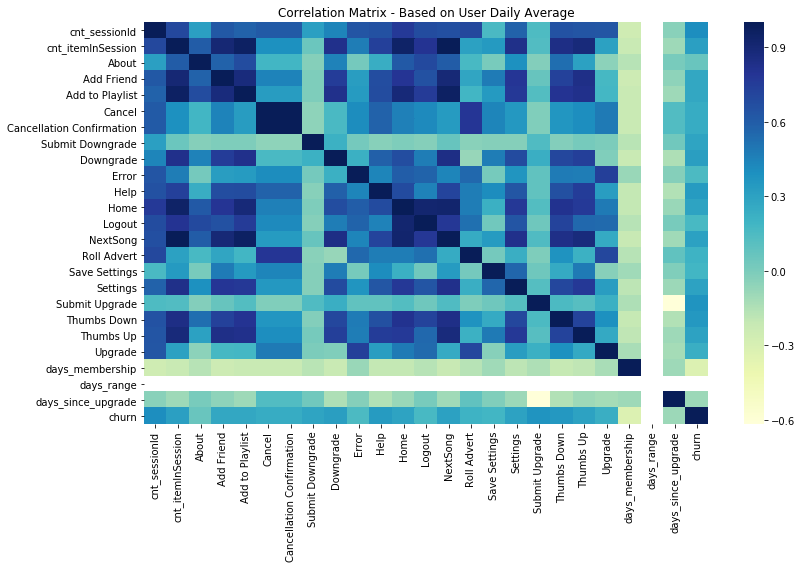

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(user_summary_pd_per_day[cols].corr(), cmap="YlGnBu")
ax.set_title("Correlation Matrix - Based on User Daily Average")
plt.tight_layout()
plt.show()

'churn' now has slightly stronger correlation to certain other columns. 

Cancel and Cancel Confirmation seem to be almost identical, while Downgrade and Submit Downgrade have weak correlation. This tells me that many people visit the Dowgrade page but do not necessarily submit.


#### user_summary_pd_per_session
Alternatively, normalising using the 'cnt_sessionId' because this represents the actual individual sessions, and may be a more accurate measure.

In [57]:
user_summary_pd_per_session = user_summary_pd.copy()
cols_per_session = ['cnt_sessionId','cnt_itemInSession','About','Add Friend','Add to Playlist',
            'Cancel','Cancellation Confirmation','Submit Downgrade',
            'Downgrade','Error','Help','Home','Logout','NextSong','Roll Advert',
            'Save Settings','Settings','Submit Upgrade','Thumbs Down','Thumbs Up',
            'Upgrade',
                #'days_membership','days_since_upgrade', 'churn'
                'days_range']
#Divide all summed columns by 'cnt_sessionId'
user_summary_pd_per_session[cols_per_session] = user_summary_pd_per_session[cols_per_session] \
    .div(user_summary_pd_per_session.cnt_sessionId, axis=0)

user_summary_pd_per_session.head()

,userId,user_type,reg_date,churn,upgrade_date,max_date,min_date,cnt_sessionId,cnt_itemInSession,About,...,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership,days_since_upgrade,days_range
0,100010,free only,2018-09-27,0,1900-01-01,2018-11-21,2018-10-08,1.0,54.428571,0.142857,...,0.000000,0.000000,0.0,0.000000,0.714286,2.428571,0.285714,55,43423,6.285714
1,200002,paying,2018-09-06,0,2018-10-18,2018-11-15,2018-10-01,1.0,79.000000,0.500000,...,0.000000,0.500000,0.0,0.166667,1.000000,3.500000,0.333333,70,28,7.500000
2,125,cancelled,2018-08-01,1,1900-01-01,2018-10-12,2018-10-12,1.0,11.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,72,43383,0.000000
3,124,paying,2018-07-22,0,1900-01-01,2018-11-30,2018-10-01,1.0,166.379310,0.241379,...,0.206897,0.689655,0.0,0.000000,1.413793,5.896552,0.000000,131,43432,2.068966
4,51,cancelled,2018-09-27,1,1900-01-01,2018-10-17,2018-10-01,1.0,246.400000,0.200000,...,0.100000,1.200000,0.0,0.000000,2.100000,10.000000,0.000000,20,43388,1.600000


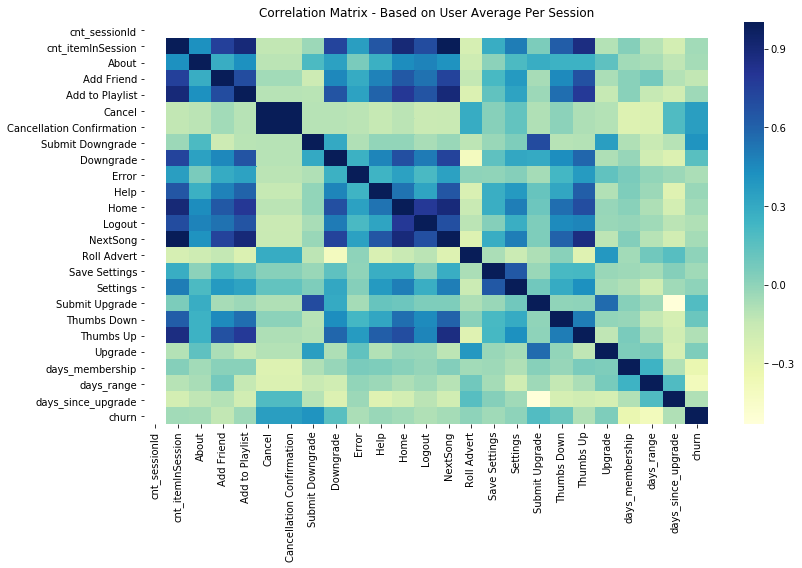

In [58]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(user_summary_pd_per_session[cols].corr(), cmap="YlGnBu")
ax.set_title("Correlation Matrix - Based on User Average Per Session")
plt.tight_layout()
plt.show()

The above chart is similar to the 1st correlation chart in 'churn' relationship with 'Cancel' etc. but it has also reduced the impact of multiple sessions on the clump of high correlated columns.

I think that this is the more accurate summarised (normalised) version of the user data, removing the bias of paying users who have more event records to draw from since I have restricted the churned users' data to pre-churn records only.

#### Days since upgrade
Now that I have the days since upgrade data calculated I hoped to see evidence of users churning within some kind of billing cycle. From the below distribution graph this does not seem to the be case. There is no clump of users around the 30day or 60 day mark, rather there instead might be a trend towards users churning with 10 days to a week of upgrading. Which still might prove useful to the model.

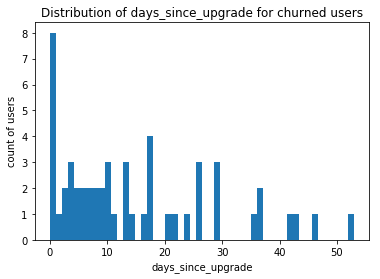

In [59]:
#days since updgrade histogram
plt.hist(data=user_summary_pd_per_session[(user_summary_pd_per_session.churn==1) & 
                        (user_summary_pd_per_session.days_since_upgrade<10000)], \
                            x='days_since_upgrade',bins=50)
plt.xlabel('days_since_upgrade')
plt.ylabel('count of users')
plt.title('Distribution of days_since_upgrade for churned users'); 

Total number of users who churned within 2 weeks of upgrading

In [60]:
user_summary_pd_per_session[(user_summary_pd_per_session.churn==1) & 
                        (user_summary_pd_per_session.days_since_upgrade<15)].shape[0]

32

Total number of churned users

In [61]:
user_summary_pd_per_session[(user_summary_pd_per_session.churn==1)].shape[0]

92

#### Boxplots to show the distribution of user interactions per user type. (And variability per day or per session)

Below, total cnt_itemInSession for distributed of all users, tends to be biased towards paying users when using the unaltered user_summary_pd

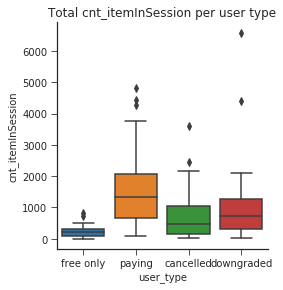

In [62]:
# Total cnt_sessionId for averaged per user type for all users
y= 'cnt_itemInSession'
with sns.axes_style(style='ticks'):
    g=sns.factorplot(x='user_type', y = y,
                     data=user_summary_pd, kind='box')
    plt.title('Total {} per user type'.format(y)); 

The below, similar graph which summarises **usage per day** has gone in the opposite direction, tends to be biased towards cancelled users

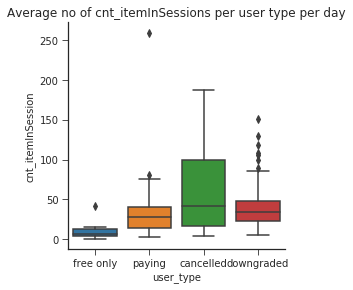

In [63]:
with sns.axes_style(style='ticks'):
    g=sns.factorplot(x='user_type',y = y,
                     data=user_summary_pd_per_day, kind='box')
    plt.title('Average no of {}s per user type per day'.format(y)); 

The below, boxplot which summarises **usage per session** is similar to the 1st boxplot in that it shows a larger distribution of total per user interactions for paying users, but it has reduced the gap between the user types. So I trust it over the above per day version graph.

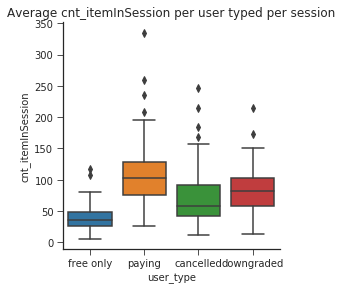

In [64]:
with sns.axes_style(style='ticks'):
    g=sns.factorplot(x='user_type',y = y,
                     data=user_summary_pd_per_session, kind='box')
    plt.title('Average {} per user typed per session'.format('cnt_itemInSession')); 

In [65]:
user_summary_pd.max_date.max()

datetime.date(2018, 12, 3)

In [66]:
user_summary_pd.max_date.min()

datetime.date(2018, 10, 1)

In [67]:
user_summary_pd.days_membership.max()

256

In [68]:
pd.options.display.max_columns = user_summary_pd.shape[1]

Looking at an example user for the spread of usage per day verus sessions. Between the min and max access dates user '55' has 55 days, but only logged in for 19. Also had 15 separate login sessions spread across those days.

In [69]:
user_summary.filter(user_summary.userId=='15').head()

Row(userId='15', user_type='paying', reg_date=datetime.date(2018, 9, 29), churn=0, upgrade_date=datetime.date(1900, 1, 1), max_date=datetime.date(2018, 11, 25), min_date=datetime.date(2018, 10, 1), cnt_sessionId=15, cnt_itemInSession=2278, About=2, Add Friend=31, Add to Playlist=59, Cancel=None, Cancellation Confirmation=None, Downgrade=28, Error=2, Help=8, Home=93, Logout=27, NextSong=1914, Roll Advert=1, Save Settings=2, Settings=16, Submit Downgrade=None, Submit Upgrade=None, Thumbs Down=14, Thumbs Up=81, Upgrade=None, days_membership=57, days_since_upgrade=43427, days_range=55)

In [70]:
df.filter(df.userId=='15').groupBy('date','sessionId').agg(count('itemInSession')
            ).sort('date','sessionId').show(50)

+----------+---------+--------------------+
|      date|sessionId|count(itemInSession)|
+----------+---------+--------------------+
|2018-10-01|      237|                  88|
|2018-10-03|      287|                 119|
|2018-10-04|      401|                 149|
|2018-10-06|      476|                 170|
|2018-10-07|      476|                  61|
|2018-10-08|      557|                   1|
|2018-10-08|      591|                 174|
|2018-10-09|      591|                 239|
|2018-10-16|      648|                 188|
|2018-10-20|      939|                   8|
|2018-10-21|      939|                  61|
|2018-10-23|     1121|                  75|
|2018-11-01|     1203|                 111|
|2018-11-02|     1203|                 190|
|2018-11-13|     1543|                  18|
|2018-11-14|     1907|                  53|
|2018-11-15|     1907|                  40|
|2018-11-15|     1949|                 116|
|2018-11-23|     1974|                 177|
|2018-11-24|     2241|          

#### Charting recent behaviour

Reproducing the original dataframe with the `max_date` per user as a new column, so that I can create a `backwards_days` column, to step backwards in days from the churned date for churned users, and see if there are trends in the days before churn compared to paying users.

In [71]:
#Create new dataframe adding 'max_date' from the user_summary data
df_new = df_sub \
   .join(user_summary.select('userId','max_date'), on=['userId'], how='inner')

In [72]:
#Add new column 'backward_days'
col_diff = date_diff(df_new.max_date, df_new.date)
df_new = df_new.withColumn('backward_days', delta_days(col_diff).cast(IntegerType()))

In [73]:
#Summarise data by user and backward_days and join with pivoted pages
summary_data_new = df_new.groupBy("userId","user_type",'backward_days'). \
    agg(countDistinct("sessionId").alias("cnt_sessionId"), 
        count("itemInSession").alias("cnt_itemInSession"))

user_pivot = df_new.groupBy("userId",'backward_days') \
    .pivot("page") \
    .count()
summary_data_new = summary_data_new.join(user_pivot, on=['userId','backward_days'],
                                         how='inner')

In [74]:
#Create as pandas dataframe to view graphs
summary_data_new_pd = summary_data_new.toPandas()
summary_data_new_pd.head()

,userId,backward_days,user_type,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,126,35,paying,1,17,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,3.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,0,paying,1,152,2.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN,7.0,5.0,124.0,NaN,NaN,1.0,NaN,NaN,1.0,3.0,NaN
2,200004,42,paying,2,73,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,59.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN
3,300002,7,downgraded,1,30,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
4,37,1,paying,1,99,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,85.0,1.0,NaN,NaN,NaN,NaN,1.0,4.0,NaN


View as boxplot distribution of the total interactions per user over the last 2 week period, excluding 'free only' users.

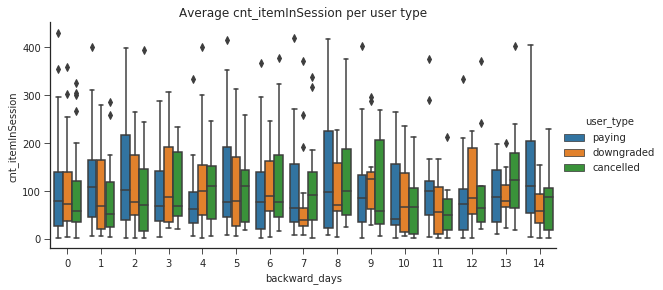

In [75]:
#Boxplot interactions per user_type per day
y='cnt_itemInSession'
data=summary_data_new_pd[(summary_data_new_pd.backward_days<15) & 
                    (summary_data_new_pd.user_type!='free only')]
with sns.axes_style(style='ticks'):
    g=sns.factorplot(data=data, x="backward_days", y=y, hue="user_type", 
                     kind='box', size=4, aspect=2)
    plt.title('Average {} per user type'.format(y)); 

Seems to show reduction in downgraded and cancelled users in the last 4 days, though the paid tier users have also reduced usage in the last few days.??

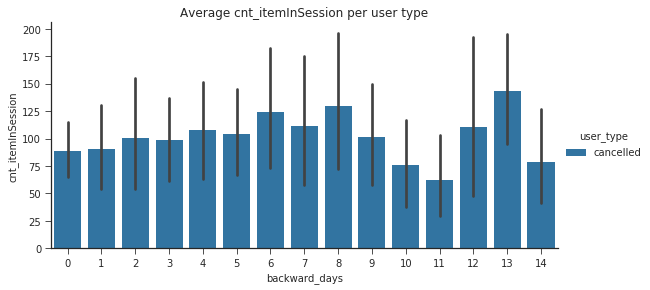

In [76]:
#Changed style to barchart
data=summary_data_new_pd[(summary_data_new_pd.backward_days<15) & 
                         (summary_data_new_pd.user_type=='cancelled')]
with sns.axes_style(style='ticks'):
    g=sns.factorplot(data=data, x="backward_days", y=y, hue="user_type", 
                     kind='bar', size=4, aspect=2)
    plt.title('Average {} per user type'.format(y)); 

The above charts seems to show a downwards trend from day 8 towards day 0 (churned date) for cancelled users. 

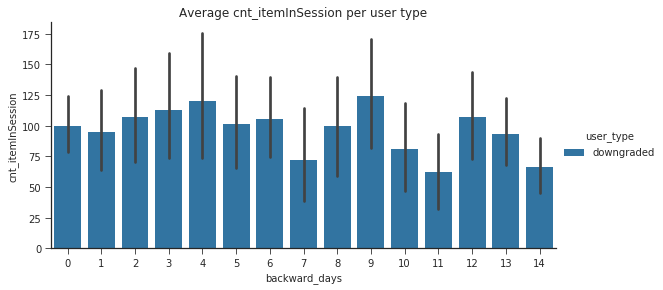

In [77]:
data=summary_data_new_pd[(summary_data_new_pd.backward_days<15) &
                         (summary_data_new_pd.user_type=='downgraded')]
with sns.axes_style(style='ticks'):
    g=sns.factorplot(data=data, x="backward_days", y=y, hue="user_type", 
                     kind='bar', size=4, aspect=2)

    plt.title('Average {} per user type'.format(y)); 

Downgraded users on the other hand have a less obvious trend pre-churn date, and a pretty irregular usage pattern prior to the last 4 days.

# Feature Engineering

#### Add last weeks columns
To incorporate some of the changes in usage we were seeing above I will add columns to the per user summary to represent the change in users' volume of interactions this week versus previous week.

In [78]:
#Sum of interactions per user in the last week
last_week = df_new.filter(df_new.backward_days<7).groupBy('userId') \
    .agg(count('itemInSession').alias('last_week_cnt_itemInSession'))

#Sum of interactions per user in the from the week before last
prev_week = df_new.filter((df_new.backward_days>6) & (df_new.backward_days<14)) \
    .groupBy('userId') \
    .agg(count('itemInSession').alias('prev_week_cnt_itemInSession'))

#Join both week's total per user
week_comp = last_week.join(prev_week, on=['userId'],
                                         how='inner')

In [79]:
#add new column to calculate the proportional change in usage last week vs this week
week_comp = week_comp.withColumn('cnt_itemInSession_change',
            (col('last_week_cnt_itemInSession') - col('prev_week_cnt_itemInSession') )
            / col('prev_week_cnt_itemInSession'))
week_comp.show(5)

+------+---------------------------+---------------------------+------------------------+
|userId|last_week_cnt_itemInSession|prev_week_cnt_itemInSession|cnt_itemInSession_change|
+------+---------------------------+---------------------------+------------------------+
|100010|                         33|                        112|     -0.7053571428571429|
|   124|                        254|                        255|    -0.00392156862745098|
|    51|                        994|                        871|     0.14121699196326062|
|    15|                        417|                        227|      0.8370044052863436|
|    54|                       1157|                        350|      2.3057142857142856|
+------+---------------------------+---------------------------+------------------------+
only showing top 5 rows



In [80]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- date: date (nullable = true)
 |-- reg_year: string (nullable = true)
 |-- reg_month: string (nullable = true)
 |-- reg_day: string (nullable = true)
 |-- reg

#### Add new column `cnt of days since last visit`
While I have chosen to normalise the summary of user data per session (instead of per day) since it seemed less biased, I still think that daily usage figures are valid potential features.

Therefore, I will add a new column to calculate the number of days still the last user site visit, compare to their average usage.

In [81]:
#Recreate the dataframe subset of pre-churn data
df_sub2 = df.filter(((df.user_type=='downgraded') & (df.pre_downgraded_events=='1')) | 
                        ((df.user_type=='cancelled') & (df.pre_cancelled_events=='1')) | 
                        (df.user_type.isin(['free only','paying'])))

In [82]:
#Create new summary daily dataframe per user 
df_daily = df_sub \
    .groupBy('userId','date') \
    .agg(countDistinct('sessionId').alias('cnt_sessionId'), \
        count('itemInSession').alias('cnt_itemInSession') \
     )

In [83]:
#find the max_date per user
df_max = df_sub \
    .groupBy('userId') \
    .agg(max('date').alias('max_date'))

In [84]:
#join the 2 together on userId
df_daily = df_daily.join(df_max, on=['userId'], how='inner')

In [85]:
#Sort on userId and date
df_daily_sorted = df_daily.sort(['userId','date'], ascending=True)
df_daily_sorted.take(5)

[Row(userId='10', date=datetime.date(2018, 10, 8), cnt_sessionId=1, cnt_itemInSession=70, max_date=datetime.date(2018, 11, 19)),
 Row(userId='10', date=datetime.date(2018, 10, 18), cnt_sessionId=1, cnt_itemInSession=345, max_date=datetime.date(2018, 11, 19)),
 Row(userId='10', date=datetime.date(2018, 10, 19), cnt_sessionId=1, cnt_itemInSession=104, max_date=datetime.date(2018, 11, 19)),
 Row(userId='10', date=datetime.date(2018, 10, 29), cnt_sessionId=1, cnt_itemInSession=25, max_date=datetime.date(2018, 11, 19)),
 Row(userId='10', date=datetime.date(2018, 11, 3), cnt_sessionId=1, cnt_itemInSession=78, max_date=datetime.date(2018, 11, 19))]

In [86]:
#Fillna(0) to remove any null values
df_daily_sorted = df_daily_sorted.na.fill(value=0)
df_daily_sorted.show(1)

+------+----------+-------------+-----------------+----------+
|userId|      date|cnt_sessionId|cnt_itemInSession|  max_date|
+------+----------+-------------+-----------------+----------+
|    10|2018-10-08|            1|               70|2018-11-19|
+------+----------+-------------+-----------------+----------+
only showing top 1 row



To calculate the difference in days between each visit I will need to create a lag in date per user daily record. This is so that i can get the both the current date and the previous visit date per user on the same line. From that point I can the calculate the difference between the 2.

To do this I have created a window partition and a date and userId lag.

In [87]:
#window partition created to push the previous date value to the next line per user, using the lag function
windowval = Window.partitionBy('userId').orderBy('date')
df_daily_sorted = df_daily_sorted.withColumn("prev_date", 
                                        lag(df_daily_sorted.date).over(windowval))

df_daily_sorted = df_daily_sorted.withColumn("prev_userId", 
                                        lag(df_daily_sorted.userId).over(windowval))

In [88]:
#Returns the previous date if not null, date otherwise 
df_daily_sorted = df_daily_sorted.withColumn('prev_date', coalesce('prev_date', 'date'))

In [89]:
df_daily_sorted.head()

Row(userId='100010', date=datetime.date(2018, 10, 8), cnt_sessionId=1, cnt_itemInSession=40, max_date=datetime.date(2018, 11, 21), prev_date=datetime.date(2018, 10, 8), prev_userId=None)

In [90]:
#add the days_since_prev_login as new column  
col_diff = date_diff(df_daily_sorted.date, df_daily_sorted.prev_date)
df_daily_sorted = df_daily_sorted.withColumn('days_since_prev_login',
                           when(((df_daily_sorted.userId == df_daily_sorted.prev_userId) | 
                                 isnan(df_daily_sorted.prev_userId)), 
                                delta_days(col_diff).cast(IntegerType())).otherwise(lit(0)))

In [91]:
df_daily_sorted.select(['userId','prev_userId','date','prev_date','days_since_prev_login']).show(5)

+------+-----------+----------+----------+---------------------+
|userId|prev_userId|      date| prev_date|days_since_prev_login|
+------+-----------+----------+----------+---------------------+
|100010|       null|2018-10-08|2018-10-08|                    0|
|100010|     100010|2018-10-15|2018-10-08|                    7|
|100010|     100010|2018-10-16|2018-10-15|                    1|
|100010|     100010|2018-10-20|2018-10-16|                    4|
|100010|     100010|2018-11-05|2018-10-20|                   16|
+------+-----------+----------+----------+---------------------+
only showing top 5 rows



In [92]:
#new dataframe days since very last login before to max_date
df_since_last_login = df_daily_sorted.select('userId','days_since_prev_login') \
        .where(df_daily_sorted.date==df_daily_sorted.max_date)

#new dataframe average days between site visits
df_avg_since_prev_login = df_daily_sorted \
    .groupBy('userId') \
    .agg(avg('days_since_prev_login').alias('avg_days_since_prev_login'))

In [93]:
#join above new dataframe on userId
df_login_join = df_avg_since_prev_login.join(df_since_last_login, on=['userId'], how='inner')

In [94]:
df_login_join.show(5)

+------+-------------------------+---------------------+
|userId|avg_days_since_prev_login|days_since_prev_login|
+------+-------------------------+---------------------+
|100010|        6.285714285714286|                   12|
|200002|        6.428571428571429|                   23|
|   125|                      0.0|                    0|
|   124|       1.8181818181818181|                    1|
|    51|       1.2307692307692308|                    1|
+------+-------------------------+---------------------+
only showing top 5 rows



In [95]:
user_summary.describe()

DataFrame[summary: string, userId: string, user_type: string, churn: string, cnt_sessionId: string, cnt_itemInSession: string, About: string, Add Friend: string, Add to Playlist: string, Cancel: string, Cancellation Confirmation: string, Downgrade: string, Error: string, Help: string, Home: string, Logout: string, NextSong: string, Roll Advert: string, Save Settings: string, Settings: string, Submit Downgrade: string, Submit Upgrade: string, Thumbs Down: string, Thumbs Up: string, Upgrade: string, days_membership: string, days_since_upgrade: string, days_range: string]

#### Updated features correlation matrix
Join the above new columns to the summary dataframe so that I can see how well they correlate to `churn`. Expecting stronger correlation compared to existing columns, or my efforts of the above cells have been in vain.

In [96]:
#Recreate the original user_summary dataframe though it now has additional columns included
user_summary = user_summary.join(df_login_join, on=['userId'], how='inner')

In [97]:
user_summary = user_summary.join(week_comp, on=['userId'], how='inner')

In [98]:
#convert to pandas dataframe to view graphs using seaborn
user_summary_pd = user_summary.toPandas()

In [99]:
#As above dividing all relevant columns by the 'cnt_sessionId' to normalize
user_summary_pd_per_session = user_summary_pd.copy()
cols_per_session = ['cnt_sessionId','cnt_itemInSession','About','Add Friend','Add to Playlist',
            'Cancel','Cancellation Confirmation','Submit Downgrade',
            'Downgrade','Error','Help','Home','Logout','NextSong','Roll Advert',
            'Save Settings','Settings','Submit Upgrade','Thumbs Down','Thumbs Up',
            'Upgrade',
                #'days_membership','days_since_upgrade', 'churn'
                'days_range']

#Divide all summed columns by 'cnt_sessionId'
user_summary_pd_per_session[cols_per_session] = user_summary_pd_per_session[cols_per_session] \
    .div(user_summary_pd_per_session.cnt_sessionId, axis=0)

user_summary_pd_per_session.head()

,userId,user_type,reg_date,churn,upgrade_date,max_date,min_date,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,...,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership,days_since_upgrade,days_range,avg_days_since_prev_login,days_since_prev_login,last_week_cnt_itemInSession,prev_week_cnt_itemInSession,cnt_itemInSession_change
0,100010,free only,2018-09-27,0,1900-01-01,2018-11-21,2018-10-08,1.0,54.428571,0.142857,0.571429,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714286,2.428571,0.285714,55,43423,6.285714,6.285714,12,33,112,-0.705357
1,124,paying,2018-07-22,0,1900-01-01,2018-11-30,2018-10-01,1.0,166.379310,0.241379,2.551724,4.068966,NaN,NaN,1.413793,...,0.206897,0.689655,NaN,NaN,1.413793,5.896552,NaN,131,43432,2.068966,1.818182,1,254,255,-0.003922
2,51,cancelled,2018-09-27,1,1900-01-01,2018-10-17,2018-10-01,1.0,246.400000,0.200000,2.800000,5.200000,0.1,0.1,2.300000,...,0.100000,1.200000,NaN,NaN,2.100000,10.000000,NaN,20,43388,1.600000,1.230769,1,994,871,0.141217
3,15,paying,2018-09-29,0,1900-01-01,2018-11-25,2018-10-01,1.0,151.866667,0.133333,2.066667,3.933333,NaN,NaN,1.866667,...,0.133333,1.066667,NaN,NaN,0.933333,5.400000,NaN,57,43427,3.666667,2.894737,1,417,227,0.837004
4,54,downgraded,2018-07-25,1,1900-01-01,2018-10-15,2018-10-01,1.0,138.500000,0.083333,1.750000,3.250000,NaN,NaN,1.583333,...,0.083333,0.416667,0.083333,NaN,0.750000,5.750000,NaN,82,43386,1.166667,1.272727,1,1157,350,2.305714


In [100]:
#list of columns to be used compared in the correlation matrix
cols = ['cnt_sessionId','cnt_itemInSession','About','Add Friend','Add to Playlist',
            'Cancel','Cancellation Confirmation','Submit Downgrade',
            'Downgrade','Error','Help','Home','Logout','NextSong','Roll Advert',
            'Save Settings','Settings','Submit Upgrade','Thumbs Down','Thumbs Up',
            'Upgrade','days_membership','days_range','days_since_upgrade',
            'avg_days_since_prev_login','days_since_prev_login','last_week_cnt_itemInSession',
            'prev_week_cnt_itemInSession','cnt_itemInSession_change', 'churn']

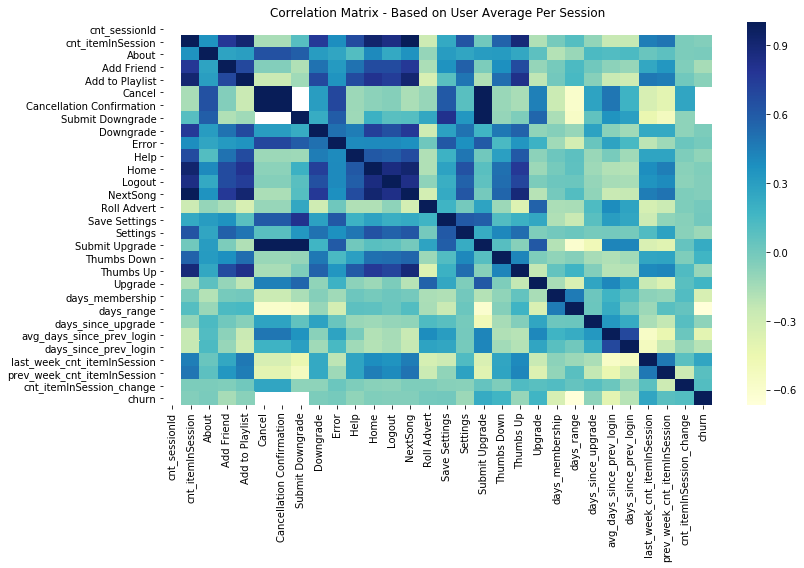

In [102]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(user_summary_pd_per_session[cols].corr(), cmap="YlGnBu")
ax.set_title("Correlation Matrix - Based on User Average Per Session")
plt.tight_layout()
plt.show()

The above correlation matrix is a comparison of almost all the model features that will be used for the models. The columns to be excluded would be the cnt_sessionId, since this is what I have divided all the page totals by, and the Cancel, Cancellation Confirmation and Submit Downgrade columns since the target column churn is derived from these.

In [103]:
#Confirming that there are no NaN values in the user_summary dataframe 
user_summary = user_summary.fillna(0)
user_summary.printSchema()

root
 |-- userId: string (nullable = true)
 |-- user_type: string (nullable = false)
 |-- reg_date: date (nullable = true)
 |-- churn: integer (nullable = false)
 |-- upgrade_date: date (nullable = true)
 |-- max_date: date (nullable = true)
 |-- min_date: date (nullable = true)
 |-- cnt_sessionId: long (nullable = false)
 |-- cnt_itemInSession: long (nullable = false)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Cancel: long (nullable = true)
 |-- Cancellation Confirmation: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullab

#### Add Downgrade_New column
Add new column `Downgrade_New` to replace `Downgrade` as a model feature. This so that I can exclude the last downgrade page visit made by users before downgrading, which might otherwise unfairly bias the model since that one interaction leeds to churn and would not be present in feature unlabeled data.

In [104]:
#For downgraded users reduce 'Downgrade' by 'Submit Downgrade' (in case multiple downgrades were made)
reduce_downgrade = udf(lambda x, y: x-y)
user_summary = user_summary.withColumn('Downgrade_New', 
     when(user_summary.user_type == 'downgraded', 
          reduce_downgrade(col('Downgrade'),col('Submit Downgrade')).cast(IntegerType())) \
     .otherwise(user_summary.Downgrade))

In [105]:
#Example downgraded user 54. Can see 'Downgrade_New' is 1 less than 'Downgrade'
user_summary.filter(user_summary.userId=='54').take(1)

[Row(userId='54', user_type='downgraded', reg_date=datetime.date(2018, 7, 25), churn=1, upgrade_date=datetime.date(1900, 1, 1), max_date=datetime.date(2018, 10, 15), min_date=datetime.date(2018, 10, 1), cnt_sessionId=12, cnt_itemInSession=1662, About=1, Add Friend=21, Add to Playlist=39, Cancel=0, Cancellation Confirmation=0, Downgrade=19, Error=1, Help=8, Home=50, Logout=15, NextSong=1420, Roll Advert=3, Save Settings=1, Settings=5, Submit Downgrade=1, Submit Upgrade=0, Thumbs Down=9, Thumbs Up=69, Upgrade=0, days_membership=82, days_since_upgrade=43386, days_range=14, avg_days_since_prev_login=1.2727272727272727, days_since_prev_login=1, last_week_cnt_itemInSession=1157, prev_week_cnt_itemInSession=350, cnt_itemInSession_change=2.3057142857142856, Downgrade_New=18)]

Translate the above updated non-pandas 'user_summary' dataframe into 'user_summary_per_session' dataframe by dividing all page interaction columns by 'cnt_sessionId', so that it can be used to drive a model.

In [106]:
user_summary_per_session = user_summary
user_summary_per_session.head()

Row(userId='100010', user_type='free only', reg_date=datetime.date(2018, 9, 27), churn=0, upgrade_date=datetime.date(1900, 1, 1), max_date=datetime.date(2018, 11, 21), min_date=datetime.date(2018, 10, 8), cnt_sessionId=7, cnt_itemInSession=381, About=1, Add Friend=4, Add to Playlist=7, Cancel=0, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, Logout=5, NextSong=275, Roll Advert=52, Save Settings=0, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, days_membership=55, days_since_upgrade=43423, days_range=44, avg_days_since_prev_login=6.285714285714286, days_since_prev_login=12, last_week_cnt_itemInSession=33, prev_week_cnt_itemInSession=112, cnt_itemInSession_change=-0.7053571428571429, Downgrade_New=0)

Define the page interaction columns which i will be dividing by the 'cnt_sessionId' to average the users page interactions per session.

In [107]:
page_interactions = ['cnt_sessionId','cnt_itemInSession','About','Add Friend','Add to Playlist',
            'Cancel','Cancellation Confirmation','Submit Downgrade','Downgrade',
            'Downgrade_New','Error','Help','Home','Logout','NextSong','Roll Advert',
            'Save Settings','Settings','Submit Upgrade','Thumbs Down','Thumbs Up',
            'Upgrade']

In [108]:
user_summary_per_session.head()

Row(userId='100010', user_type='free only', reg_date=datetime.date(2018, 9, 27), churn=0, upgrade_date=datetime.date(1900, 1, 1), max_date=datetime.date(2018, 11, 21), min_date=datetime.date(2018, 10, 8), cnt_sessionId=7, cnt_itemInSession=381, About=1, Add Friend=4, Add to Playlist=7, Cancel=0, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, Logout=5, NextSong=275, Roll Advert=52, Save Settings=0, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, days_membership=55, days_since_upgrade=43423, days_range=44, avg_days_since_prev_login=6.285714285714286, days_since_prev_login=12, last_week_cnt_itemInSession=33, prev_week_cnt_itemInSession=112, cnt_itemInSession_change=-0.7053571428571429, Downgrade_New=0)

In [109]:
#Udf to divide each column value by the cnt_sessionId value
user_summary_per_session = user_summary

divide_col = udf(lambda x, y: x/y)
y = 'cnt_sessionId'

for c in page_interactions: #.remove('days_membership')
    user_summary_per_session = user_summary_per_session.withColumn(c,
        divide_col(col(c),col(y)).cast(IntegerType()))

# Modeling
The models being used are RandomForestClassifier and LogisticRegression since both are classification models, and the analysis metric will be AUC.

### RandomForestClassifier Model
The below list of features excludes `Cancel`,`Cancellation Confirmation`, `Submit Downgrade` and `Downgrade` columns which the label column `churn` is derived from.

In [110]:
#chosen model features
features = ['cnt_itemInSession','About','Add Friend','Add to Playlist',
            'Downgrade_New','Error','Help','Home','Logout','NextSong','Roll Advert',
            'Save Settings','Settings','Submit Upgrade','Thumbs Down','Thumbs Up',
            'Upgrade','days_membership','days_since_upgrade',
            'avg_days_since_prev_login','days_since_prev_login','last_week_cnt_itemInSession',
            'prev_week_cnt_itemInSession','cnt_itemInSession_change']

#create new vector column based on the above lits of features
assembler = VectorAssembler(inputCols=features, outputCol="features")

indexer = StringIndexer(inputCol="churn", outputCol="label")

In [111]:
#Split the data into training and validation datasets
x_train, x_test = user_summary_per_session.randomSplit([0.7, 0.3])

#### 1st run of the model
Initial randomforestclassifier hyperparameters are the estimator defaults (just stated below for visibility). At a later tuning phase i will experiment with other parameter values. This 1st version is to see what the default version produces.

In [161]:
#RandomForestClassifier with default hyperparameter values
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=5, numTrees=20)

#pipeline assembles the above vector assembler, output indexer and RandomForestClassifier
pipeline = Pipeline(stages=[assembler, indexer, rf])

#train the RandomForestClassifier model and use to create test predictions
rf_Model = pipeline.fit(x_train)
y_test = rf_Model.transform(x_test)

In [162]:
#Number of correct predictions on using the above data on the validation dataset
y_test.filter(y_test.label == y_test.prediction).count()

40

In [163]:
#Number of total values in test data
y_test.count()

48

In [164]:
#use a binaryClassificationEvaluator since it is a binary problem, using AUC
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(y_test, {evaluator.metricName: 'areaUnderROC'})
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.173611


The above model produces pretty low test error considering only using default model hyperparameters.

#### RandomForestClassifier Model Tuning 
Re-running using a paramgridbuilder and cross validator so to tune the maxdepth and numtrees parameters. Doubled the maxdepth value, and increased the numtrees to 50.

In [165]:
paramGrid = ParamGridBuilder() \
  .addGrid(rf.maxDepth, [5,10]) \
  .addGrid(rf.numTrees, [20,50]) \
  .build()

cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps=paramGrid,
                    evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC'),
                    numFolds=3)

cvModel = cv.fit(x_train)

In [166]:
#zip cvModel getEstimatorParamMaps() and avgMetrics, and add to list
param_list = list()

for params, score in zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics):
      param_list.append((([{param.name: str(params[param])} for param in params]),
                         "Score: {:0.3f}".format(score)))

In [167]:
#print ParamMaps and corresponding AUC scores
param_list

[([{'maxDepth': '5'}, {'numTrees': '20'}], 'Score: 0.813'),
 ([{'maxDepth': '5'}, {'numTrees': '50'}], 'Score: 0.819'),
 ([{'maxDepth': '10'}, {'numTrees': '20'}], 'Score: 0.830'),
 ([{'maxDepth': '10'}, {'numTrees': '50'}], 'Score: 0.816')]

Fromt the above training data AUC scores 'maxDepth': '5' and 'numTrees': '50' have produced the best model. 

In [168]:
predictions = cvModel.transform(x_test)

In [169]:
print(predictions.filter(predictions.label == predictions.prediction).count())
print(predictions.count())

40
48


Compute the model accuracy metrics for comparison to the LogisticRegression model. 

The below Test Error shows a slight improvement on the initial model above, so hyperparameter tuning did lead to an improvement.

In [170]:
# calculate AUC accuracy metric on the validation data
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
print("Test Error = %g" % (1.0 - accuracy))
# compute TN, TP, FN, and FP
predictions.groupBy('label', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

Test Error = 0.167535
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   18|
|  0.0|       1.0|    2|
|  1.0|       0.0|    6|
|  0.0|       0.0|   22|
+-----+----------+-----+

n precision: 0.900
n recall: 0.750
n accuracy: 0.833
n F1 score: 0.818


### Logistic Regression Model

For the LogisticRegression model I went straight to cross validation and hyperparameter tuning. I have tried a couple of variations of maxIter using the below code cells. Initially I used a `lr.maxIter, [1,5,10]` but I found that the highest value within that grid produced the best avgMetrics.

Therefore in the below cells I have increased the maxIter to `lr.maxIter, [10,20,50]` to test whether increasing the maxIter further will further improve the model accuracy.

In [129]:
lr = LogisticRegression(labelCol="label", featuresCol="features")

In [130]:
#utilising the same vector assembler and indexer as fed the above randomforestclassifier
pipeline_lr = Pipeline(stages=[assembler, indexer, lr])

In [171]:
paramGrid_lr = ParamGridBuilder() \
  .addGrid(lr.maxIter, [10,20,50]) \
  .addGrid(lr.regParam, [0.0,0.5,2.0]) \
  .build()

cv_lr = CrossValidator(estimator=pipeline_lr, 
                    estimatorParamMaps=paramGrid_lr,
                    evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC'),
                    numFolds=2)

cvModel_lr = cv_lr.fit(x_train)

In [172]:
#zip cvModel getEstimatorParamMaps() and avgMetrics, and add to list
param_list = list()

for params, score in zip(cvModel_lr.getEstimatorParamMaps(), cvModel_lr.avgMetrics):
      param_list.append((([{param.name: str(params[param])} for param in params]),
                         "Score: {:0.3f}".format(score)))

In [173]:
#print ParamMaps and corresponding AUC scores
param_list

[([{'maxIter': '10'}, {'regParam': '0.0'}], 'Score: 0.834'),
 ([{'maxIter': '10'}, {'regParam': '0.5'}], 'Score: 0.856'),
 ([{'maxIter': '10'}, {'regParam': '2.0'}], 'Score: 0.847'),
 ([{'maxIter': '20'}, {'regParam': '0.0'}], 'Score: 0.808'),
 ([{'maxIter': '20'}, {'regParam': '0.5'}], 'Score: 0.848'),
 ([{'maxIter': '20'}, {'regParam': '2.0'}], 'Score: 0.846'),
 ([{'maxIter': '50'}, {'regParam': '0.0'}], 'Score: 0.773'),
 ([{'maxIter': '50'}, {'regParam': '0.5'}], 'Score: 0.848'),
 ([{'maxIter': '50'}, {'regParam': '2.0'}], 'Score: 0.846')]

From the above list {'maxIter': '10', 'regParam': '0.5', 'Score: 0.856'} has produced the best model, so there was no benefit to increasing the maxIter parameter since was the best model from my previous 1,5,10 run.

In [174]:
predictions = cvModel_lr.transform(x_test)

In [175]:
print(predictions.filter(predictions.label == predictions.prediction).count())
print(predictions.count())

36
48


In [176]:
# calculate AUC accuracy metric on the validation data
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
print("Test Error = %g" % (1.0 - accuracy))
# compute TN, TP, FN, and FP
predictions.groupBy('label', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)
print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)

Test Error = 0.232639
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   14|
|  0.0|       1.0|    2|
|  1.0|       0.0|   10|
|  0.0|       0.0|   22|
+-----+----------+-----+

n precision: 0.875
n recall: 0.583
n accuracy: 0.750
n F1 score: 0.700


# Conclusion

Of the two models tested the tuned RandomForestClassifier performed the best with the best AUC scores producing less than 17% error on the 128MB mini dataset that was used. It had better precision, and achieved a higher level of accuracy faster, even before tuning, while LogisticRegression model required more tuning and flex of the maxIter parameter.